In [9]:
# Import necessary libraries
import os
import cv2 as cv
import numpy as np
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from mtcnn import MTCNN  # MTCNN for face detection


In [10]:
# Directory where dataset is stored
DIR = r'D:\9th Semester\CVPR [B]\FINAL\Assignment\Assignment_1\data'  # Update this path with your dataset's location
people = ['moynul']  # List of people for training


In [11]:
# Initialize MTCNN face detector
detector = MTCNN()


In [12]:
# Features and labels initialization
features = []
labels = []

# Function to create training data
def create_training_data():
    for person in people:
        path = os.path.join(DIR, person)
        label = people.index(person)

        for img in os.listdir(path):
            img_path = os.path.join(path, img)
            img_array = cv.imread(img_path)
            img_rgb = cv.cvtColor(img_array, cv.COLOR_BGR2RGB)  # Convert to RGB
            
            # Detect faces using MTCNN
            faces = detector.detect_faces(img_rgb)

            for face in faces:
                x, y, w, h = face['box']
                face_roi = img_rgb[y:y + h, x:x + w]
                resized_face = cv.resize(face_roi, (224, 224))  # Resize for MobileNetV2 input
                resized_face = np.array(resized_face)  # Ensure the resized image is an array
                features.append(resized_face)
                labels.append(label)

# Call function to create training data
create_training_data()


In [13]:
# Convert to numpy arrays
features = np.array(features, dtype='float32') / 255.0  # Normalize pixel values
labels = np.array(labels)

# Ensure features have the shape (224, 224, 3)
print(f'Initial Features shape: {features.shape}')  # Print initial features shape

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=len(people))
y_val = to_categorical(y_val, num_classes=len(people))

# Ensure the shapes of training and validation data
print(f'Training data shape: {X_train.shape}')  # Print training data shape
print(f'Validation data shape: {X_val.shape}')  # Print validation data shape


Initial Features shape: (74, 224, 224, 3)
Training data shape: (59, 224, 224, 3)
Validation data shape: (15, 224, 224, 3)


In [14]:
# Load MobileNetV2 base model (pre-trained on ImageNet)
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Build the transfer learning model on top of MobileNetV2
model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(people), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the transfer learning model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=32
)

# Save the trained transfer learning model
model.save('face_recognition_mobileNetV2.h5')
print("Transfer learning model training complete and saved.")


Epoch 1/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step - accuracy: 1.0

Transfer learning model training complete and saved.


In [15]:
# Load the trained model
model = load_model('face_recognition_mobileNetV2.h5')

# Initialize webcam (for local setup)
cap = cv.VideoCapture(0)

if not cap.isOpened():
    print("Error: Could not access the webcam.")
    exit()

while True:
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame from the webcam. Exiting...")
        break

    img_rgb = cv.cvtColor(frame, cv.COLOR_BGR2RGB)  # Convert to RGB

    # Detect faces using MTCNN
    faces = detector.detect_faces(img_rgb)

    for face in faces:
        x, y, w, h = face['box']
        face_roi = img_rgb[y:y + h, x:x + w]
        resized_face = cv.resize(face_roi, (224, 224))
        normalized_face = resized_face / 255.0
        reshaped_face = normalized_face.reshape(1, 224, 224, 3)  # 3 channels for RGB

        # Predict using the transfer learning model
        predictions = model.predict(reshaped_face)
        confidence = np.max(predictions) * 100

        if confidence < 50:
            label_text = f'Unknown Person ({confidence:.2f}%)'
        else:
            label = np.argmax(predictions)
            label_text = f'{people[label]} ({confidence:.2f}%)'

        # Display label and confidence on the video feed
        cv.putText(frame, label_text, (x, y - 10), cv.FONT_HERSHEY_COMPLEX, 0.7, (0, 255, 0), 2)
        cv.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Display the real-time video feed (use normal OpenCV window in Visual Studio)
    cv.imshow("Webcam - Face Recognition", frame)

    # Exit the webcam feed when 'q' is pressed
    if cv.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close OpenCV windows
cap.release()
cv.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━

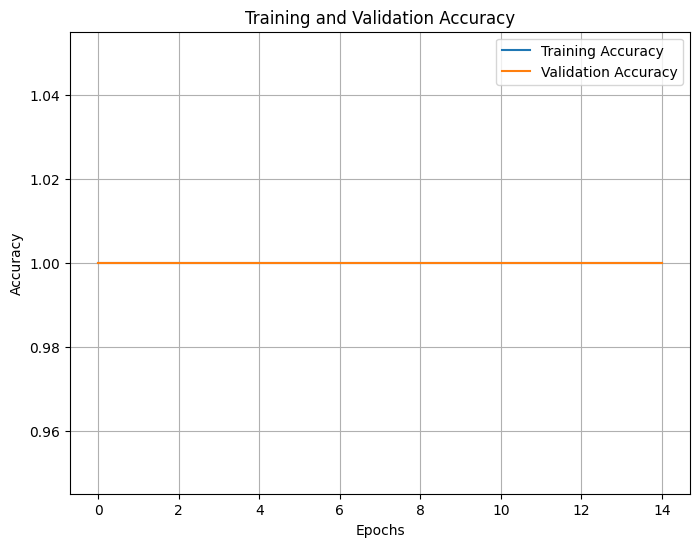

In [16]:
import matplotlib.pyplot as plt

# Get training and validation accuracy from history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
